In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import xesmf as xe

from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import averaging_utils as avg
from qtrendutils import filter_utils as filt
from qtrendutils import calendar_utils as cal

plt.rc('font', family='Arial')

from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm

In [12]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

### Land mask on the 1 degree grid

In [13]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = xr.where(landfrac > 0, 1, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Aridity index on the 1 degree grid

In [14]:
pet_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020.nc")
pet_tc = pet_tc.mean('time')
ppt_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020.nc")
ppt_tc = ppt_tc.mean('time')
aridity = ppt_tc.ppt / pet_tc.pet
aridity['lon'] = landfrac.lon ; aridity['lat'] = landfrac.lat

### Read in the trends in HadISDH specific humidity to determine the grid points to use.  Omitting grid points where there are nan's or an insufficient number of months in the data.  Interpolating the 1 degree land frac to determine the landfrac

In [15]:
hadisdh_q = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/qtrends_HadISDH.nc")
hadisdh_q = hadisdh_q.rename({'longitude':'lon', 'latitude':'lat'})
grid_out = xr.Dataset({'lat':(['lat'], hadisdh_q.lat.values)}, {'lon':(['lon'], hadisdh_q.lon.values)})

# define the regridder
regridder = xe.Regridder(landfrac, grid_out, 'bilinear', periodic=True, reuse_weights=False, filename='/project/cas/islas/temp/wgtfile.nc')

landfrac_5deg = regridder(landfrac)
landfrac_5deg = xr.where( landfrac_5deg > 0, 1, nan)
landfrac_5deg = landfrac_5deg.where(landfrac_5deg > -60, nan)

# omitting the grid points that don't have enough data by looking for NaN's in the HadISDH annual mean 1980 to 2020 humidity trend
landfrac_5deg = landfrac_5deg.where( ~np.isnan(hadisdh_q.q), nan)

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


### Regrid the aridity index onto the 5 degree grid and define the masks for the different regions on this grid

In [16]:
aridity_5deg = regridder(aridity)

aridmask = landfrac.where( (aridity > 0.05) & (aridity < 0.5), nan)
aridmask_5deg = landfrac_5deg.where( (aridity_5deg > 0.05) & (aridity_5deg < 0.5), nan)

humidmask = landfrac.where( (aridity >= 0.5), nan)
humidmask_5deg = landfrac_5deg.where( (aridity_5deg >= 0.5), nan)

hyperaridmask = landfrac.where( (aridity <= 0.05), nan)
hyperaridmask_5deg = landfrac_5deg.where( (aridity_5deg <= 0.05), nan)

### Read in Specific humidity time series.  Calculate anomalies from 1980 to 1990.  Regrid ERA5 to the 5 degrid calculate the 12 month running mean

In [17]:
era5_q_ts = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ERA5.nc").sel(time=slice("1980-01","2020-12")).q
era5_q_ts['lon'] = landfrac.lon ; era5_q_ts['lat'] = landfrac.lat

hadisdh_q_ts = xr.open_dataset("/project/mojave/observations/HadISDH/gridded/"+
                             "HadISDH.landq.4.4.0.2021f_FLATgridHOM5by5_anoms9120.nc")
hadisdh_q_ts = hadisdh_q_ts.sel(time=slice("1980-01","2020-12"))
hadisdh_q_ts = hadisdh_q_ts.q_abs
hadisdh_q_ts = hadisdh_q_ts.rename({'longitude':'lon', 'latitude':'lat'})

era5_q_ts_5deg = regridder(era5_q_ts)

era5_q_ts_arid = avg.cosweightlonlat(era5_q_ts*aridmask,0,360,-90,90)
era5_q_ts_humid = avg.cosweightlonlat(era5_q_ts*humidmask,0,360,-90,90)
era5_q_ts_hyperarid = avg.cosweightlonlat(era5_q_ts*hyperaridmask,0,360,-90,90)
era5_q_ts_all = avg.cosweightlonlat(era5_q_ts*landfrac,0,360,-90,90)

era5_q_ts_5deg_arid = avg.cosweightlonlat(era5_q_ts_5deg*aridmask_5deg,0,360,-90,90)
era5_q_ts_5deg_humid = avg.cosweightlonlat(era5_q_ts_5deg*humidmask_5deg,0,360,-90,90)
era5_q_ts_5deg_hyperarid = avg.cosweightlonlat(era5_q_ts_5deg*hyperaridmask_5deg,0,360,-90,90)
era5_q_ts_5deg_all = avg.cosweightlonlat(era5_q_ts_5deg*landfrac_5deg,0,360,-90,90)

hadisdh_q_ts_arid = avg.cosweightlonlat(hadisdh_q_ts*aridmask_5deg,0,360,-90,90)
hadisdh_q_ts_humid = avg.cosweightlonlat(hadisdh_q_ts*humidmask_5deg,0,360,-90,90)
hadisdh_q_ts_hyperarid = avg.cosweightlonlat(hadisdh_q_ts*hyperaridmask_5deg,0,360,-90,90)
hadisdh_q_ts_all = avg.cosweightlonlat(hadisdh_q_ts*landfrac_5deg,0,360,-90,90)

era5_q_ts_arid_anoms = era5_q_ts_arid - era5_q_ts_arid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_humid_anoms = era5_q_ts_humid - era5_q_ts_humid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_hyperarid_anoms = era5_q_ts_hyperarid - era5_q_ts_hyperarid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_all_anoms = era5_q_ts_all - era5_q_ts_all.sel(time=slice("1980-01-01","1990-12-31")).mean('time')

era5_q_ts_5deg_arid_anoms = era5_q_ts_5deg_arid - era5_q_ts_5deg_arid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_5deg_humid_anoms = era5_q_ts_5deg_humid - era5_q_ts_5deg_humid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_5deg_hyperarid_anoms = era5_q_ts_5deg_hyperarid - era5_q_ts_5deg_hyperarid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
era5_q_ts_5deg_all_anoms = era5_q_ts_5deg_all - era5_q_ts_5deg_all.sel(time=slice("1980-01-01","1990-12-31")).mean('time')

hadisdh_q_ts_arid_anoms = hadisdh_q_ts_arid - hadisdh_q_ts_arid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
hadisdh_q_ts_humid_anoms = hadisdh_q_ts_humid - hadisdh_q_ts_humid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
hadisdh_q_ts_hyperarid_anoms = hadisdh_q_ts_hyperarid - hadisdh_q_ts_hyperarid.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
hadisdh_q_ts_all_anoms = hadisdh_q_ts_all - hadisdh_q_ts_all.sel(time=slice("1980-01-01","1990-12-31")).mean('time')

flipping longitudes
flipping longitudes
flipping longitudes
flipping longitudes
flipping longitudes
flipping longitudes
flipping longitudes
flipping longitudes


### Calculate 12 month running means

In [18]:
era5_q_ts_arid_12m = filt.runningmean(era5_q_ts_arid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_humid_12m = filt.runningmean(era5_q_ts_humid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_hyperarid_12m = filt.runningmean(era5_q_ts_hyperarid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_all_12m = filt.runningmean(era5_q_ts_all_anoms, 12, timeaxis='time', dropna=False)

era5_q_ts_5deg_arid_12m = filt.runningmean(era5_q_ts_5deg_arid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_5deg_humid_12m = filt.runningmean(era5_q_ts_5deg_humid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_5deg_hyperarid_12m = filt.runningmean(era5_q_ts_5deg_hyperarid_anoms, 12, timeaxis='time', dropna=False)
era5_q_ts_5deg_all_12m = filt.runningmean(era5_q_ts_5deg_all_anoms, 12, timeaxis='time', dropna=False)

hadisdh_q_ts_arid_12m = filt.runningmean(hadisdh_q_ts_arid_anoms, 12, timeaxis='time', dropna=False)
hadisdh_q_ts_humid_12m = filt.runningmean(hadisdh_q_ts_humid_anoms, 12, timeaxis='time', dropna=False)
hadisdh_q_ts_hyperarid_12m = filt.runningmean(hadisdh_q_ts_hyperarid_anoms, 12, timeaxis='time', dropna=False)
hadisdh_q_ts_all_12m = filt.runningmean(hadisdh_q_ts_all_anoms, 12, timeaxis='time', dropna=False)

### Read in the CMIP6 global averages

In [19]:
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/global_avgs/"
cmip6_q = xr.open_dataset(basepath+'CMIP6_q.nc')*1000.
cmip6_q = cmip6_q.sel(time=slice("1980-01-01","2020-12-31"))
cmip6_q_anoms = cmip6_q - cmip6_q.sel(time=slice("1980-01-01","1990-12-31")).mean('time')
cmip6_q_12m = filt.runningmean(cmip6_q_anoms, 12, timeaxis='time', dropna=False)
cmip6_q_am = cal.calcannualmean(cmip6_q_anoms)
timemonth_cmip = np.arange(0,cmip6_q.time.size,1)*(1./12.) + 1980
cmip6_q_memm = cmip6_q_12m.mean('member')
cmip6_q_em = cmip6_q_memm.mean('model')

cmip6_q_12m_stack = cmip6_q_12m.stack(z=('member','model'))
cmip6_q_12m_stack = cmip6_q_12m_stack.where( ~np.isnan(cmip6_q_12m_stack.isel(time=240)), drop=True)

cmip6_q_am_stack = cmip6_q_am.stack(z=('member','model'))
cmip6_q_am_stack = cmip6_q_am_stack.dropna('z')

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


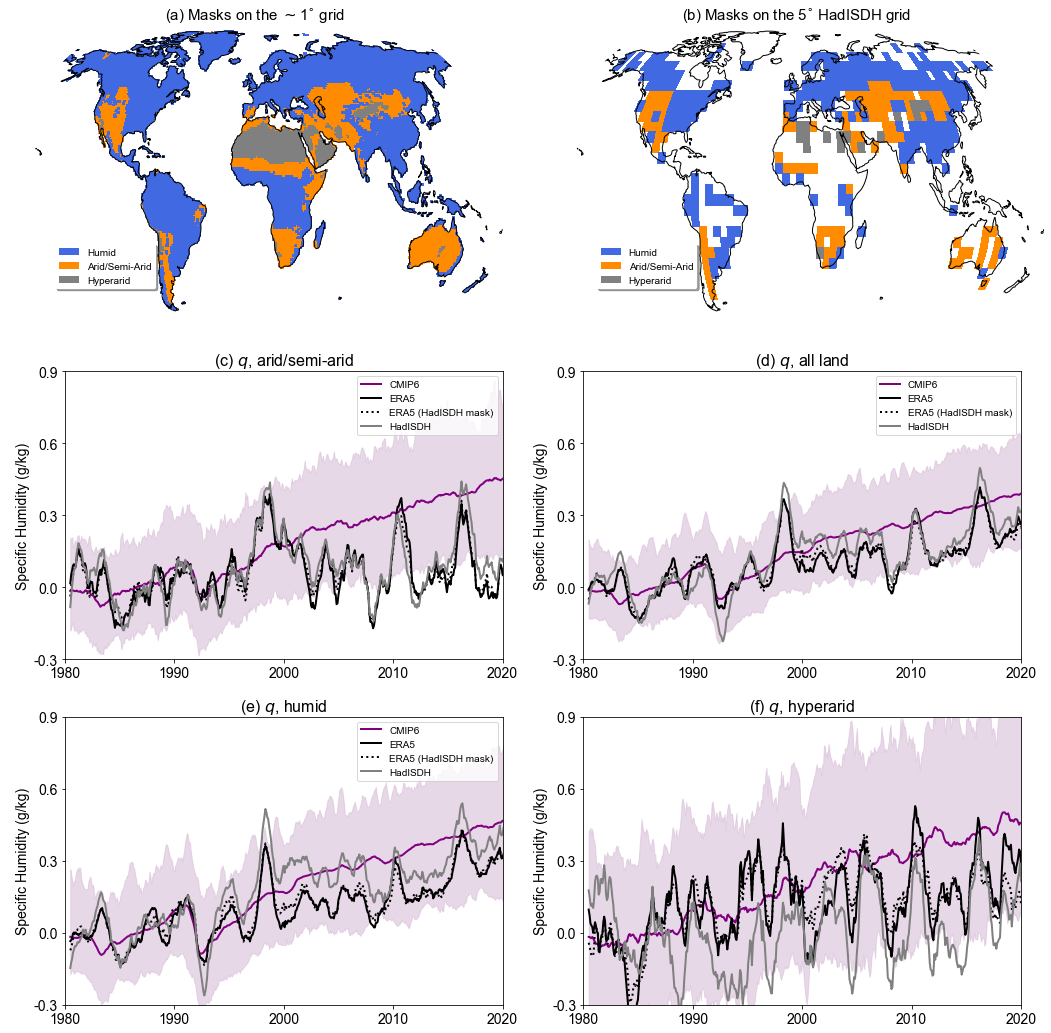

In [20]:
fig = plt.figure(figsize=(16,16))

#-----Masks on the 1 deg grid
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, aridmask, aridmask.lon, aridmask.lat,0.1,-1,1,'(a) Masks on the $\sim$1$^{\circ}$ grid',
                                                              0.05,0.48,0.75,1,onecolor=True, color='darkorange')
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, hyperaridmask, hyperaridmask.lon, hyperaridmask.lat, 0.1, -1, 1, ' ',
                                                              0.05,0.48,0.74,1,onecolor=True, color='gray', oplot=True, ax=ax)
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, humidmask, humidmask.lon, humidmask.lat, 0.1, -1, 1, ' ',
                                                              0.05,0.48,0.74,1,onecolor=True, color='royalblue', oplot=True, ax=ax)

legendparts = [ Rectangle((0.95,0.95),3,3,facecolor='royalblue'),
                Rectangle((0.95,0.95),3,3,facecolor='darkorange'),
                Rectangle((0.95,0.95),3,3,facecolor='gray')]
legendlabels=['Humid','Arid/Semi-Arid','Hyperarid']
ax.legend(legendparts, legendlabels, bbox_to_anchor=(0.31,0.26), ncol=1,frameon=True, facecolor='white', edgecolor='None',
          framealpha=None, shadow=True)
#-----------------------------


#-----Masks on the 5 deg grid
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, aridmask_5deg, aridmask_5deg.lon, aridmask_5deg.lat,0.1,-1,1,'(b) Masks on the 5$^{\circ}$ HadISDH grid',
                                                              0.52,0.95,0.75,1,onecolor=True, color='darkorange')
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, hyperaridmask_5deg, hyperaridmask_5deg.lon, hyperaridmask_5deg.lat, 0.1, -1, 1, ' ',
                                                              0.52,0.95,0.74,1,onecolor=True, color='gray', oplot=True, ax=ax)
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, humidmask_5deg, humidmask_5deg.lon, humidmask_5deg.lat, 0.1, -1, 1, ' ',
                                                              0.52,0.95,0.74,1,onecolor=True, color='royalblue', oplot=True, ax=ax)

legendparts = [ Rectangle((0.95,0.95),3,3,facecolor='royalblue'),
                Rectangle((0.95,0.95),3,3,facecolor='darkorange'),
                Rectangle((0.95,0.95),3,3,facecolor='gray')]
legendlabels=['Humid','Arid/Semi-Arid','Hyperarid']
ax.legend(legendparts, legendlabels, bbox_to_anchor=(0.31,0.26), ncol=1,frameon=True, facecolor='white', edgecolor='None',
          framealpha=None, shadow=True)

#----------------Arid
ax = fig.add_axes([0.1,0.45,0.38,0.25])
ax.set_xlim(1980,2020)
ax.set_ylim(-0.3,0.9)
ax.set_yticks([-0.3,0,0.3,0.6,0.9])
ax.set_yticklabels(['-0.3','0.0','0.3','0.6','0.9'], fontsize=14)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize=14)
ax.set_title('(c) $q$, arid/semi-arid', fontsize=16)

min95_cmip6 = cmip6_q_12m_stack['arid'].quantile(0.025, dim='z')
max95_cmip6 = cmip6_q_12m_stack['arid'].quantile(0.975, dim='z')
ax.fill_between(timemonth_cmip, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)    
ax.plot(timemonth_cmip, cmip6_q_em['arid'], color='purple', linewidth=2, label='CMIP6')

ax.plot(1980 + np.arange(0,era5_q_ts_arid_12m.time.size,1)/12., 1000.*era5_q_ts_arid_12m, color='black', linewidth=2, label='ERA5')
ax.plot(1980 + np.arange(0,era5_q_ts_5deg_arid_12m.time.size,1)/12., 1000.*era5_q_ts_5deg_arid_12m, color='black', linewidth=2, linestyle='dotted', label='ERA5 (HadISDH mask)')
ax.plot(1980 + np.arange(0,hadisdh_q_ts_arid_12m.time.size,1)/12., hadisdh_q_ts_arid_12m, color='gray', linewidth=2, label='HadISDH')
ax.legend()

#---------------End Arid

#---------------All land
ax = fig.add_axes([0.55,0.45,0.38,0.25])
ax.set_xlim(1980,2020)
ax.set_ylim(-0.3,0.9)
ax.set_yticks([-0.3,0,0.3,0.6,0.9])
ax.set_yticklabels(['-0.3','0.0','0.3','0.6','0.9'], fontsize=14)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize=14)
ax.set_title('(d) $q$, all land', fontsize=16)

min95_cmip6 = cmip6_q_12m_stack['allland'].quantile(0.025, dim='z')
max95_cmip6 = cmip6_q_12m_stack['allland'].quantile(0.975, dim='z')
ax.fill_between(timemonth_cmip, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)    
ax.plot(timemonth_cmip, cmip6_q_em['allland'], color='purple', linewidth=2, label='CMIP6')

ax.plot(1980 + np.arange(0,era5_q_ts_all_12m.time.size,1)/12., 1000.*era5_q_ts_all_12m, color='black', linewidth=2, label='ERA5')
ax.plot(1980 + np.arange(0,era5_q_ts_5deg_all_12m.time.size,1)/12., 1000.*era5_q_ts_5deg_all_12m, color='black', linewidth=2, 
             linestyle='dotted', label='ERA5 (HadISDH mask)')
ax.plot(1980 + np.arange(0,hadisdh_q_ts_all_12m.time.size,1)/12., hadisdh_q_ts_all_12m, color='gray', linewidth=2, label='HadISDH')

ax.legend()
#--------------End All Land

#--------------Humid
ax = fig.add_axes([0.1,0.15,0.38,0.25])
ax.set_xlim(1980,2020)
ax.set_ylim(-0.3,0.9)
ax.set_yticks([-0.3,0,0.3,0.6,0.9])
ax.set_yticklabels(['-0.3','0.0','0.3','0.6','0.9'], fontsize=14)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize=14)
ax.set_title('(e) $q$, humid', fontsize=16)

min95_cmip6 = cmip6_q_12m_stack['humid'].quantile(0.025, dim='z')
max95_cmip6 = cmip6_q_12m_stack['humid'].quantile(0.975, dim='z')
ax.fill_between(timemonth_cmip, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)    
ax.plot(timemonth_cmip, cmip6_q_em['humid'], color='purple', linewidth=2, label='CMIP6')

ax.plot(1980 + np.arange(0,era5_q_ts_humid_12m.time.size,1)/12., 1000.*era5_q_ts_humid_12m, color='black', linewidth=2, label='ERA5')
ax.plot(1980 + np.arange(0,era5_q_ts_5deg_humid_12m.time.size,1)/12., 1000.*era5_q_ts_5deg_humid_12m, color='black', linewidth=2, 
                      linestyle='dotted', label='ERA5 (HadISDH mask)')
ax.plot(1980 + np.arange(0,hadisdh_q_ts_humid_12m.time.size,1)/12., hadisdh_q_ts_humid_12m, color='gray', linewidth=2, label='HadISDH')

ax.legend()
#--------------End Humid

#--------------Hyperarid
ax = fig.add_axes([0.55,0.15,0.38,0.25])
ax.set_xlim(1980,2020)
ax.set_ylim(-0.3,0.9)
ax.set_yticks([-0.3,0,0.3,0.6,0.9])
ax.set_yticklabels(['-0.3','0.0','0.3','0.6','0.9'], fontsize=14)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylabel('Specific Humidity (g/kg)', fontsize=14)
ax.set_title('(f) $q$, hyperarid', fontsize=16)

min95_cmip6 = cmip6_q_12m_stack['hyperarid'].quantile(0.025, dim='z')
max95_cmip6 = cmip6_q_12m_stack['hyperarid'].quantile(0.975, dim='z')
ax.fill_between(timemonth_cmip, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)    
ax.plot(timemonth_cmip, cmip6_q_em['hyperarid'], color='purple', linewidth=2, label='CMIP6')

ax.plot(1980 + np.arange(0,era5_q_ts_hyperarid_12m.time.size,1)/12., 1000.*era5_q_ts_hyperarid_12m, color='black', linewidth=2, label='ERA5')
ax.plot(1980 + np.arange(0,era5_q_ts_5deg_hyperarid_12m.time.size,1)/12., 1000.*era5_q_ts_5deg_hyperarid_12m, color='black', linewidth=2, 
                            linestyle='dotted', label='ERA5 (HadISDH mask)')
ax.plot(1980 + np.arange(0,hadisdh_q_ts_hyperarid_12m.time.size,1)/12., hadisdh_q_ts_hyperarid_12m, color='gray', linewidth=2, label='HadISDH')
#--------------End Hyperarid

fig.savefig(plotpath+'figS23.pdf', bbox_inches='tight', facecolor='white')
#fig.savefig(plotpath+'compare_hadisdh_era5_12m_timeseries.png', bbox_inches='tight', facecolor='white')